In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Entendendo os fatores que levam a um melhor desempenho na classificação geral (cg)

In [2]:
# Load the dataset
data = pd.read_csv(
    "../data/df_pooled_ranking_clean.csv"
)  # Replace with your dataset path

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nome                  1646 non-null   object 
 1   ano                   1646 non-null   int64  
 2   anos_pm               1646 non-null   float64
 3   bolsista_encoded      1646 non-null   int64  
 4   cg                    1646 non-null   float64
 5   diff_fase             1646 non-null   float64
 6   iaa                   1646 non-null   float64
 7   ian                   1646 non-null   float64
 8   ida                   1646 non-null   float64
 9   idade                 1646 non-null   float64
 10  ieg                   1646 non-null   float64
 11  inde                  1646 non-null   float64
 12  ipp                   1646 non-null   float64
 13  ips                   1646 non-null   float64
 14  ipv                   1646 non-null   float64
 15  na_fase              

In [3]:
data.set_index("nome", inplace=True)

data["ano"] = data["ano"].astype(int)

data["bolsista_encoded"] = data["bolsista_encoded"].astype(int)

data["cg"] = data["cg"].astype(int)

data["ian"] = data["ian"].astype("category")

data["na_fase"] = data["na_fase"].astype(int)

data["ponto_virada_encoded"] = data["ponto_virada_encoded"].astype(int)

data["sexo_encoded"] = data["sexo_encoded"].astype(int)

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   int64   
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [4]:
data.loc[data["ano"] != 2022, "cg"] = np.nan


## Considerando que não temos o ranking dos anos anteriores, qual a variável definitiva para a sua definição?

In [5]:
df = data.copy()
df = df.dropna(subset=["cg"])
df.head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-2,2022,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1
ALUNO-4,2022,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0
ALUNO-5,2022,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0
ALUNO-6,2022,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1
ALUNO-7,2022,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0


In [6]:
# # Step 1: Feature Selection using Random Forest
# features_for_importance = df.drop(columns=["cg"])
# target_for_importance = df["cg"]

# # Standardize the features
# scaler = StandardScaler()
# features_scaled_for_importance = scaler.fit_transform(features_for_importance)

# # Train a Random Forest to get feature importance
# rf = RandomForestRegressor(random_state=42)
# rf.fit(features_scaled_for_importance, target_for_importance)

# # Get feature importances and sort them
# importances = rf.feature_importances_
# feature_names = features_for_importance.columns
# sorted_indices = np.argsort(importances)[::-1]

# # Print the most important features
# print("Feature ranking:")
# for i in sorted_indices:
#     print(f"{feature_names[i]}: {importances[i]}")


def features_eval(df, target_feature):
    # Step 1: Feature Selection using Random Forest
    features_for_importance = df.drop(columns=[target_feature])
    target_for_importance = df[target_feature]

    # Standardize the features
    scaler = StandardScaler()
    features_scaled_for_importance = scaler.fit_transform(features_for_importance)

    # Train a Random Forest to get feature importance
    rf = RandomForestRegressor(random_state=42)
    rf.fit(features_scaled_for_importance, target_for_importance)

    # Get feature importances and sort them
    importances = rf.feature_importances_
    feature_names = features_for_importance.columns
    sorted_indices = np.argsort(importances)[::-1]

    # Print the most important features
    print("Feature ranking:")
    for i in sorted_indices:
        print(f"{feature_names[i]}: {importances[i]}")
    return feature_names[sorted_indices]


features_eval(df, "cg")


Feature ranking:
inde: 0.9999604207034338
ida: 6.450235229912001e-06
ipv: 5.703408232569696e-06
ieg: 5.619562093275832e-06
ipp: 4.317378117407441e-06
iaa: 4.120746252544992e-06
idade: 3.0283669639519128e-06
anos_pm: 2.8432248829636834e-06
ips: 2.345538977785719e-06
diff_fase: 1.7250871353563491e-06
sexo_encoded: 1.4122128040479032e-06
ian: 6.857451858915493e-07
na_fase: 6.482690465724951e-07
ponto_virada_encoded: 3.574124260538529e-07
bolsista_encoded: 3.2210921768804024e-07
ano: 0.0


Index(['inde', 'ida', 'ipv', 'ieg', 'ipp', 'iaa', 'idade', 'anos_pm', 'ips',
       'diff_fase', 'sexo_encoded', 'ian', 'na_fase', 'ponto_virada_encoded',
       'bolsista_encoded', 'ano'],
      dtype='object')

A variável que dita a classificação geral é o `inde`. Então vamos definir a classificação para os anos anteriores:

In [7]:
def set_cg(df):
    df = df.sort_values(by="inde", ascending=False)
    df.reset_index(inplace=True)
    df["cg"] = pd.Series(range(1, len(df) + 1))
    df.set_index("nome", inplace=True)

    return df


cg_2021 = set_cg(data[data["ano"] == 2021][["inde", "cg"]])
cg_2022 = set_cg(data[data["ano"] == 2022][["inde", "cg"]])

# fill cg values in the original dataframe with the new cg values for the corresponding year
data.loc[cg_2021.index, "cg"] = cg_2021["cg"]
data.loc[cg_2022.index, "cg"] = cg_2022["cg"]

data.sort_values(by="cg", ascending=True).head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-75,2020,1.0,1,1.0,1.0,10.00002,10.0,9.000000,11.0,10.000000,9.687504,9.37500,10.000,9.750010,0,1,1
ALUNO-75,2021,2.0,1,1.0,1.0,10.00000,10.0,8.500000,12.0,9.200000,9.108000,8.80000,7.500,9.700000,0,1,1
ALUNO-75,2022,3.0,1,1.0,2.0,10.00002,10.0,8.500000,13.0,9.660714,9.441522,9.21875,9.375,9.750010,0,1,1
ALUNO-916,2022,5.0,1,2.0,0.0,8.75001,10.0,8.511111,15.0,10.000000,9.354308,9.06250,9.375,9.666675,1,1,1
ALUNO-916,2021,4.0,1,2.0,0.0,8.30000,10.0,7.800000,14.0,9.700000,8.866000,9.20000,7.500,9.300000,1,1,1


Escreve em arquivo o resultado da definição do cg:

In [8]:
data.to_csv("../data/df_pooled_ranking_clean_with_cg.csv")


## Faz sentido realizar a análise considerando a variação do `cg` no tempo?

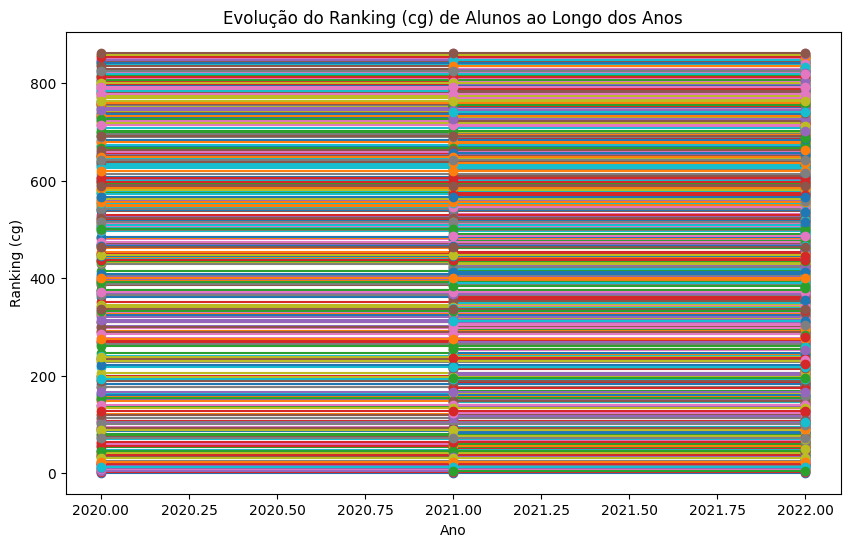

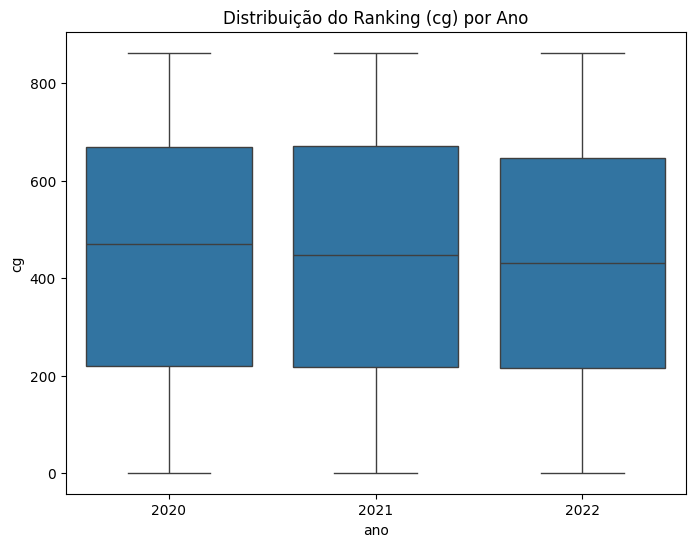

             mean  std
aluno_id              
ALUNO-100   720.0  0.0
ALUNO-1000  592.0  NaN
ALUNO-1001  367.0  0.0
ALUNO-1002  289.0  0.0
ALUNO-1004   88.0  0.0
...           ...  ...
ALUNO-994   340.0  0.0
ALUNO-995   419.0  0.0
ALUNO-996   465.0  0.0
ALUNO-997   151.0  0.0
ALUNO-998   220.0  NaN

[862 rows x 2 columns]
Resultado do teste ANOVA: F_onewayResult(statistic=0.5861200781897649, pvalue=0.5565985213615023)


In [9]:
# Carregar os dados
df = data.copy().reset_index().rename({"nome": "aluno_id"}, axis=1)


# 1. Agrupar os dados por aluno e ano, selecionando as colunas relevantes
# Suponho que exista uma coluna 'aluno_id' que identifica cada aluno e 'ano' para o ano específico
# Adapte o nome da coluna 'aluno_id' caso necessário
df_sorted = df.sort_values(by=["aluno_id", "ano"])

# 2. Calcular a diferença do ranking cg entre os anos para cada aluno
df["cg_diff_2021_2020"] = df.groupby("aluno_id")["cg"].diff(periods=1)
df["cg_diff_2022_2021"] = df.groupby("aluno_id")["cg"].diff(periods=2)

# 3. Visualizar a evolução do ranking de cada aluno ao longo do tempo com um gráfico de linhas
plt.figure(figsize=(10, 6))
for aluno in df["aluno_id"].unique():
    aluno_data = df[df["aluno_id"] == aluno]
    plt.plot(aluno_data["ano"], aluno_data["cg"], marker="o", label=f"Aluno {aluno}")

plt.title("Evolução do Ranking (cg) de Alunos ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Ranking (cg)")
# plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

# 4. Criar boxplots para comparar a distribuição de cg em cada ano
plt.figure(figsize=(8, 6))
sns.boxplot(x="ano", y="cg", data=df, legend=False)
plt.title("Distribuição do Ranking (cg) por Ano")
plt.show()

# 5. Analisar a variação do ranking de cada aluno
df_variation = df.groupby("aluno_id")["cg"].agg(["mean", "std"])
print(df_variation)

# Opcional: realizar um teste ANOVA para verificar se a variação de cg entre os anos é significativa
from scipy.stats import f_oneway

# Criar listas com os valores de cg por ano
cg_2020 = df[df["ano"] == 2020]["cg"]
cg_2021 = df[df["ano"] == 2021]["cg"]
cg_2022 = df[df["ano"] == 2022]["cg"]

# Teste ANOVA para ver se há diferença significativa nos rankings entre os anos
anova_result = f_oneway(cg_2020, cg_2021, cg_2022)
print("Resultado do teste ANOVA:", anova_result)


### Resultado da ANOVA quanto à variação temporal da classificação no tempo:

O p-value de 0.556 é maior que o nível de significância usual de 0.05 (ou 5%). Isso significa que não há evidências suficientes para rejeitar a hipótese nula.

Hipótese nula (H₀): O ranking (cg) dos alunos não varia significativamente entre os anos.
Hipótese alternativa (H₁): O ranking (cg) dos alunos varia significativamente entre os anos.
Dado que o p-value é alto, não podemos concluir que existe uma diferença significativa entre os rankings nos diferentes anos. Em outras palavras, o teste ANOVA sugere que a variação dos rankings entre os anos de 2020, 2021 e 2022 não é estatisticamente significativa.

Logo, uma abordagem razoável é utilizar a média dos indicadores e nos outros casos somente os dados de 2022.

In [10]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   float64 
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [11]:
df = data.reset_index().copy()
df = df[df["ano"] == 2022]
df = df.drop(columns=["ano"], axis=1)
df.set_index("nome", inplace=True)
df.head()


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,
ALUNO-2,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1
ALUNO-4,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0
ALUNO-5,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0
ALUNO-6,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1
ALUNO-7,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0


## Teste com os dados de 2022, uma vez que não há diferença substancial ao longo dos anos para a definição do `cg`

In [12]:
df_2022 = pd.read_csv("../data/df_2022_preproc_select.csv")

df_2022.head()


,nome,idade,fase,turma,ano_ingresso,bolsista,inde,cg,cf,ct,...,destaque_ipv_resultado_encoded,rec_ava_1_resultado,rec_ava_2_resultado,rec_ava_3_resultado,rec_ava_4_resultado,rec_ava_1_resultado_encoded,rec_ava_2_resultado_encoded,rec_ava_3_resultado_encoded,rec_ava_4_resultado_encoded,rec_sintese
0,ALUNO-2,11.0,0,K,2022.0,Não,7.675509,245.0,66.0,6.0,...,1,Positivo,Neutro,NaN,NaN,1.0,0.0,NaN,NaN,1.0
1,ALUNO-4,12.0,2,J,2022.0,Não,7.117065,451.0,69.0,3.0,...,1,Positivo,Neutro,Positivo,NaN,1.0,0.0,1.0,NaN,1.0
2,ALUNO-5,12.0,2,L,2019.0,Não,7.232336,415.0,61.0,12.0,...,1,Neutro,Positivo,Neutro,NaN,0.0,1.0,0.0,NaN,0.0
3,ALUNO-6,11.0,2,K,2022.0,Não,7.741669,221.0,35.0,2.0,...,1,Neutro,Positivo,Neutro,NaN,0.0,1.0,0.0,NaN,0.0
4,ALUNO-7,11.0,1,U,2022.0,Não,7.406743,357.0,93.0,7.0,...,1,Positivo,Positivo,NaN,NaN,1.0,1.0,NaN,NaN,1.0


In [13]:
df_2022.columns.to_list()


['nome',
 'idade',
 'fase',
 'turma',
 'ano_ingresso',
 'bolsista',
 'inde',
 'cg',
 'cf',
 'ct',
 'iaa',
 'ieg',
 'ips',
 'ida',
 'nota_port',
 'nota_mat',
 'nota_ing',
 'qtd_aval',
 'ipp',
 'indicado_bolsa',
 'ipv',
 'ian',
 'nivel_ideal',
 'sexo',
 'corraca',
 'bolsista_encoded',
 'ponto_virada_encoded',
 'pedra',
 'pedra_encoded',
 'anos_pm',
 'fase_ideal',
 'destaque_ieg_resultado',
 'destaque_ida_resultado',
 'destaque_ipv_resultado',
 'destaque_ieg_resultado_encoded',
 'destaque_ida_resultado_encoded',
 'destaque_ipv_resultado_encoded',
 'rec_ava_1_resultado',
 'rec_ava_2_resultado',
 'rec_ava_3_resultado',
 'rec_ava_4_resultado',
 'rec_ava_1_resultado_encoded',
 'rec_ava_2_resultado_encoded',
 'rec_ava_3_resultado_encoded',
 'rec_ava_4_resultado_encoded',
 'rec_sintese']

In [14]:
df_2022 = df_2022[
    [
        "nome",
        "idade",
        "cg",
        "pedra",
        "inde",
        "iaa",
        "ieg",
        "ips",
        "ida",
        "ipv",
        "ian",
        "ipp",
        "qtd_aval",
        "indicado_bolsa",
        "sexo",
        "ponto_virada_encoded",
        "fase",
        "anos_pm",
        "fase_ideal",
        "destaque_ieg_resultado_encoded",
        "destaque_ida_resultado_encoded",
        "destaque_ipv_resultado_encoded",
        "rec_sintese",
    ]
].copy()


df_2022.head()


,nome,idade,cg,pedra,inde,iaa,ieg,ips,ida,ipv,...,indicado_bolsa,sexo,ponto_virada_encoded,fase,anos_pm,fase_ideal,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese
0,ALUNO-2,11.0,245.0,Ametista,7.675509,10.00002,7.581705,7.5,8.816667,7.916665,...,Sim,F,0,0,0.0,2.0,1,1,1,1.0
1,ALUNO-4,12.0,451.0,Ametista,7.117065,10.00002,8.071429,7.5,5.083333,8.055553,...,Não,M,0,2,0.0,3.0,1,-1,1,1.0
2,ALUNO-5,12.0,415.0,Ametista,7.232336,6.41668,8.557505,7.5,7.083333,7.833337,...,Não,M,0,2,3.0,3.0,1,-1,1,0.0
3,ALUNO-6,11.0,221.0,Ametista,7.741669,9.00002,9.333333,7.5,5.500000,7.500000,...,Não,F,0,2,0.0,2.0,1,-1,1,0.0
4,ALUNO-7,11.0,357.0,Ametista,7.406743,10.00002,9.314954,7.5,5.583333,7.916670,...,Não,M,0,1,0.0,2.0,1,-1,1,1.0


In [15]:
df_2022["diff_fase"] = df_2022["fase"] - df_2022["fase_ideal"]
df_2022.drop(columns=["fase_ideal", "fase"], inplace=True)
df_2022.head()


,nome,idade,cg,pedra,inde,iaa,ieg,ips,ida,ipv,...,qtd_aval,indicado_bolsa,sexo,ponto_virada_encoded,anos_pm,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase
0,ALUNO-2,11.0,245.0,Ametista,7.675509,10.00002,7.581705,7.5,8.816667,7.916665,...,2.0,Sim,F,0,0.0,1,1,1,1.0,-2.0
1,ALUNO-4,12.0,451.0,Ametista,7.117065,10.00002,8.071429,7.5,5.083333,8.055553,...,3.0,Não,M,0,0.0,1,-1,1,1.0,-1.0
2,ALUNO-5,12.0,415.0,Ametista,7.232336,6.41668,8.557505,7.5,7.083333,7.833337,...,3.0,Não,M,0,3.0,1,-1,1,0.0,-1.0
3,ALUNO-6,11.0,221.0,Ametista,7.741669,9.00002,9.333333,7.5,5.500000,7.500000,...,3.0,Não,F,0,0.0,1,-1,1,0.0,0.0
4,ALUNO-7,11.0,357.0,Ametista,7.406743,10.00002,9.314954,7.5,5.583333,7.916670,...,2.0,Não,M,0,0.0,1,-1,1,1.0,-1.0


In [16]:
df_2022.to_csv("../data/df_2022_clustering.csv")


### Adequação de `cg` para o algoritmo - normalização e inversão (quanto menor, melhor)

In [17]:
df = pd.read_csv("../data/df_2022_clustering.csv")

# Definir o valor mínimo e máximo da coluna "cg"
min_cg = df["cg"].min()
max_cg = df["cg"].max()

# Aplicar a normalização inversa para refletir a ordem de melhor ranking
df["cg_normalized_inverted"] = 1 - (df["cg"] - min_cg) / (max_cg - min_cg)

# Exibir as primeiras linhas da normalização invertida
df_sorted_inverted = df[["cg", "cg_normalized_inverted"]].sort_values(by="cg").head()
print(df_sorted_inverted)


      cg  cg_normalized_inverted
50   1.0                1.000000
583  2.0                0.998839
104  3.0                0.997677
852  4.0                0.996516
594  5.0                0.995354


### Random Forest para análise de fatores que contribuem para melhor cg

In [18]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.isna().sum()


nome                              0
idade                             0
cg                                0
pedra                             0
inde                              0
iaa                               0
ieg                               0
ips                               0
ida                               0
ipv                               0
ian                               0
ipp                               0
qtd_aval                          0
indicado_bolsa                    0
sexo                              1
ponto_virada_encoded              0
anos_pm                           0
destaque_ieg_resultado_encoded    0
destaque_ida_resultado_encoded    0
destaque_ipv_resultado_encoded    0
rec_sintese                       2
diff_fase                         0
cg_normalized_inverted            0
dtype: int64

In [19]:
corr_matrix = df.drop(
    columns=["nome", "pedra", "sexo", "indicado_bolsa"], axis=1
).corr()

corr_matrix.style.background_gradient(cmap="coolwarm")


,idade,cg,inde,iaa,ieg,ips,ida,ipv,ian,ipp,qtd_aval,ponto_virada_encoded,anos_pm,destaque_ieg_resultado_encoded,destaque_ida_resultado_encoded,destaque_ipv_resultado_encoded,rec_sintese,diff_fase,cg_normalized_inverted
idade,1.000000,0.359791,-0.360518,-0.264404,-0.320758,-0.104236,-0.318002,-0.210611,-0.324827,0.488370,0.770615,-0.006744,0.386114,-0.265611,-0.234062,-0.131788,0.228327,-0.363567,-0.359791
cg,0.359791,1.000000,-0.956312,-0.396569,-0.741294,-0.276923,-0.807916,-0.757219,-0.421310,-0.251662,0.178120,-0.474279,0.073761,-0.652172,-0.619161,-0.625367,-0.325611,-0.417172,-1.000000
inde,-0.360518,-0.956312,1.000000,0.463363,0.805282,0.274220,0.820710,0.791634,0.394684,0.285240,-0.196463,0.428505,-0.066108,0.660809,0.551292,0.584382,0.317259,0.402606,0.956312
iaa,-0.264404,-0.396569,0.463363,1.000000,0.330733,0.118804,0.217989,0.263990,0.048871,-0.106104,-0.284307,0.112605,-0.110769,0.259722,0.145692,0.142289,-0.040211,0.032574,0.396569
ieg,-0.320758,-0.741294,0.805282,0.330733,1.000000,0.098460,0.570141,0.595315,0.163949,0.136132,-0.225718,0.266648,-0.103558,0.827673,0.337453,0.438571,0.127216,0.217780,0.741294
ips,-0.104236,-0.276923,0.274220,0.118804,0.098460,1.000000,0.137056,0.211818,0.035888,0.058641,-0.066487,0.149198,-0.251987,0.077672,0.159034,0.158868,0.006076,0.060193,0.276923
ida,-0.318002,-0.807916,0.820710,0.217989,0.570141,0.137056,1.000000,0.622190,0.148094,0.116916,-0.252861,0.337622,-0.048272,0.478871,0.692144,0.492725,0.385585,0.180582,0.807916
ipv,-0.210611,-0.757219,0.791634,0.263990,0.595315,0.211818,0.622190,1.000000,0.113478,0.337496,-0.190860,0.568919,0.016995,0.481471,0.456455,0.726575,0.387259,0.172207,0.757219
ian,-0.324827,-0.421310,0.394684,0.048871,0.163949,0.035888,0.148094,0.113478,1.000000,0.120675,0.026875,0.074775,-0.031090,0.139518,0.084545,0.087452,0.008158,0.838126,0.421310
ipp,0.488370,-0.251662,0.285240,-0.106104,0.136132,0.058641,0.116916,0.337496,0.120675,1.000000,0.687126,0.282521,0.349191,0.078670,0.031813,0.239203,0.423634,0.152042,0.251662


### Análise simplifica de clusterização

In [20]:
def evaluate_features_importance(df, target_col, categorical_features):
    # Definir as variáveis independentes (excluir colunas irrelevantes como 'nome', 'cg', 'cg_normalized_inverted')
    # X = df.drop(columns=["nome", "cg", "cg_normalized_inverted", "inde", "pedra"])
    # y = df["cg_normalized_inverted"]
    X = df.drop(columns=target_col)
    y = df[target_col]

    # Dividir os dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Definir pré-processamento para variáveis categóricas (ex: 'pedra' e 'sexo')
    # categorical_features = ["sexo", "indicado_bolsa"]
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    numerical_features = X.drop(columns=categorical_features).columns.tolist()

    numerical_transformer = SimpleImputer(
        strategy="mean"
    )  # Para preencher valores numéricos ausentes
    categorical_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="most_frequent"),
            ),  # Preencher categóricos com o valor mais frequente
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore"),
            ),  # OneHotEncode para variáveis categóricas
        ]
    )

    # Criação do ColumnTransformer para aplicar transformações adequadas a variáveis categóricas e numéricas
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Modelo usando RandomForest
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(random_state=42)),
        ]
    )

    # Dividir os dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    print("R²:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))

    importances = model.named_steps["regressor"].feature_importances_
    # Extrair nomes das features após a transformação (incluindo categorias expandidas pelo OneHotEncoder)
    feature_names = (
        model.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    )
    all_features = numerical_features + feature_names.tolist()

    # Criar dataframe de importância
    importance_df = pd.DataFrame(
        {"Feature": all_features, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)
    print(importance_df)
    # Ordenar a importância das variáveis em ordem decrescente
    importance_df = pd.DataFrame(
        {"Feature": all_features, "Importance": importances}
    ).sort_values(by="Importance", ascending=False)

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("Importância")
    plt.ylabel("Features")
    plt.title("Importância das Features")
    plt.gca().invert_yaxis()  # Inverter o eixo Y para mostrar as features mais importantes no topo
    plt.show()


R²: 0.9065413151650048
MAE: 0.0710430807033091
                           Feature  Importance
4                              ipv    0.403015
2                              ieg    0.318924
11  destaque_ida_resultado_encoded    0.118051
14                       diff_fase    0.040276
5                              ian    0.037759
1                              iaa    0.027587
3                              ips    0.015639
6                              ipp    0.013412
0                            idade    0.009177
9                          anos_pm    0.005360
13                     rec_sintese    0.001860
7                         qtd_aval    0.001541
16                          sexo_M    0.001535
10  destaque_ieg_resultado_encoded    0.001388
8             ponto_virada_encoded    0.001359
15                          sexo_F    0.001087
18              indicado_bolsa_Sim    0.000889
17              indicado_bolsa_Não    0.000626
12  destaque_ipv_resultado_encoded    0.000514


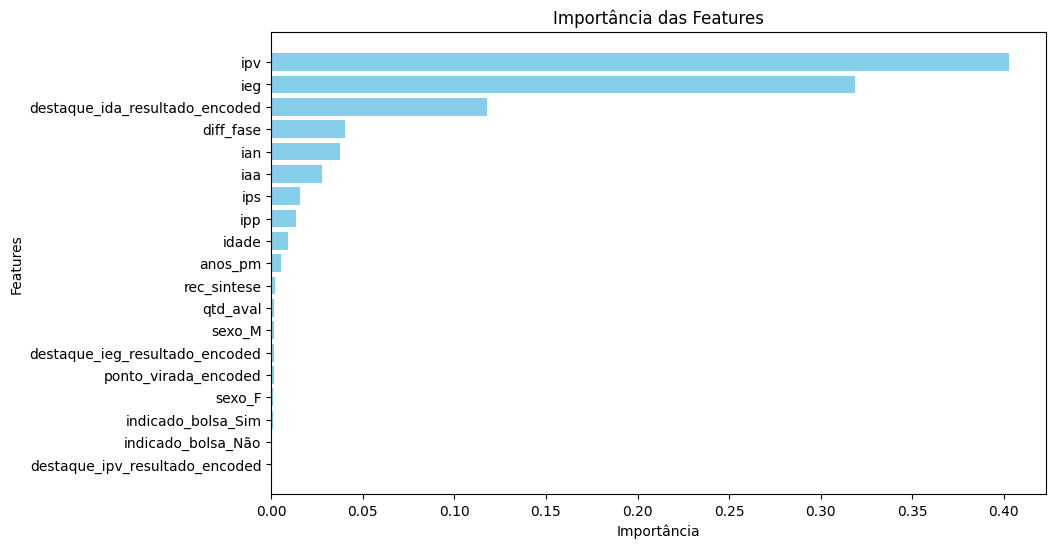

In [21]:
df_to_evaluate = df.drop(columns=["nome", "cg", "inde", "pedra", "ida"])

evaluate_features_importance(
    df_to_evaluate,
    "cg_normalized_inverted",
    ["sexo", "indicado_bolsa"],
)


R²: 0.9685270833857983
MAE: 0.04148630776150867
                           Feature  Importance
4                              ida    0.519559
23                     pedra_Ágata    0.145818
22                   pedra_Topázio    0.101718
20                  pedra_Ametista    0.087259
21                   pedra_Quartzo    0.061228
5                              ipv    0.026012
2                              ieg    0.020769
1                              iaa    0.008142
15                       diff_fase    0.005490
6                              ian    0.005278
7                              ipp    0.004515
3                              ips    0.004456
0                            idade    0.002705
10                         anos_pm    0.001587
12  destaque_ida_resultado_encoded    0.001209
9             ponto_virada_encoded    0.001114
8                         qtd_aval    0.000572
17                          sexo_M    0.000438
11  destaque_ieg_resultado_encoded    0.000435
16          

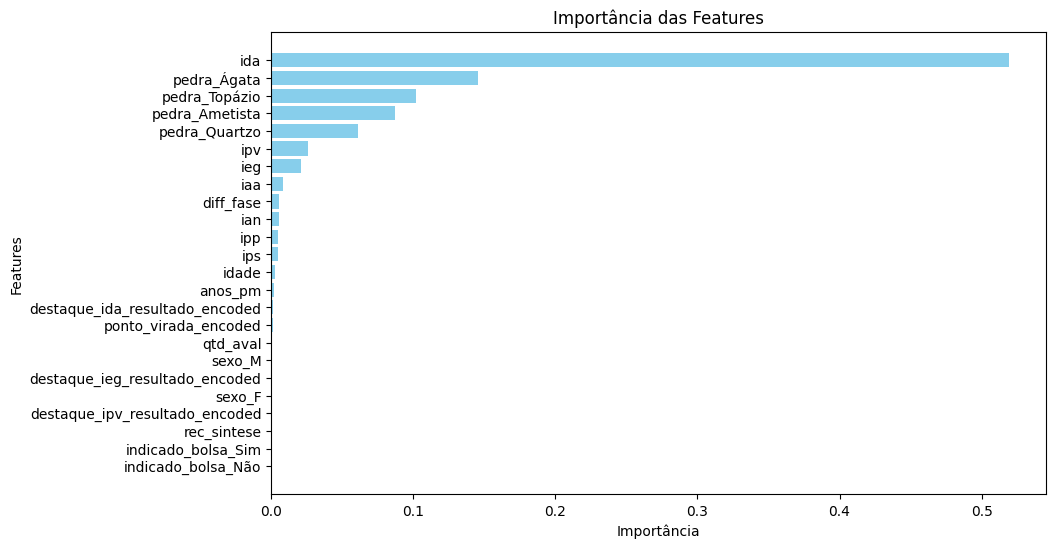

In [22]:
df_to_evaluate = df.drop(columns=["nome", "cg", "inde"])
evaluate_features_importance(
    df_to_evaluate, "cg_normalized_inverted", ["sexo", "indicado_bolsa", "pedra"]
)


In [23]:
df_to_evaluate.columns


Index(['idade', 'pedra', 'iaa', 'ieg', 'ips', 'ida', 'ipv', 'ian', 'ipp',
       'qtd_aval', 'indicado_bolsa', 'sexo', 'ponto_virada_encoded', 'anos_pm',
       'destaque_ieg_resultado_encoded', 'destaque_ida_resultado_encoded',
       'destaque_ipv_resultado_encoded', 'rec_sintese', 'diff_fase',
       'cg_normalized_inverted'],
      dtype='object')

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_to_evaluate = df.drop(columns=["nome", "cg", "inde"])


# Pré-processamento de variáveis categóricas
# Codificar a variável 'Genero'
le = LabelEncoder()
df_to_evaluate["sexo_Encoded"] = le.fit_transform(df["sexo"])
df_to_evaluate["bolsa_Encoded"] = le.fit_transform(df["indicado_bolsa"])

# Aplicar One-Hot Encoding na variável 'Curso'
df_pedra_encoded = pd.get_dummies(df["pedra"], prefix="predra")

# Concatenar as variáveis codificadas ao DataFrame original
df_to_evaluate = pd.concat([df_to_evaluate, df_pedra_encoded], axis=1)

# Visualizar o DataFrame atualizado
print("DataFrame com variáveis categóricas codificadas:")
print(df_to_evaluate.head())


DataFrame com variáveis categóricas codificadas:
   idade     pedra       iaa       ieg  ips       ida       ipv   ian  \
0   11.0  Ametista  10.00002  7.581705  7.5  8.816667  7.916665   5.0   
1   12.0  Ametista  10.00002  8.071429  7.5  5.083333  8.055553   5.0   
2   12.0  Ametista   6.41668  8.557505  7.5  7.083333  7.833337   5.0   
3   11.0  Ametista   9.00002  9.333333  7.5  5.500000  7.500000  10.0   
4   11.0  Ametista  10.00002  9.314954  7.5  5.583333  7.916670   5.0   

        ipp  qtd_aval  ... destaque_ipv_resultado_encoded rec_sintese  \
0  5.625000       2.0  ...                              1         1.0   
1  6.250000       3.0  ...                              1         1.0   
2  6.458333       3.0  ...                              1         0.0   
3  6.250000       3.0  ...                              1         0.0   
4  5.937500       2.0  ...                              1         1.0   

   diff_fase  cg_normalized_inverted  sexo_Encoded  bolsa_Encoded  \
0   

In [25]:
df_to_evaluate.columns


Index(['idade', 'pedra', 'iaa', 'ieg', 'ips', 'ida', 'ipv', 'ian', 'ipp',
       'qtd_aval', 'indicado_bolsa', 'sexo', 'ponto_virada_encoded', 'anos_pm',
       'destaque_ieg_resultado_encoded', 'destaque_ida_resultado_encoded',
       'destaque_ipv_resultado_encoded', 'rec_sintese', 'diff_fase',
       'cg_normalized_inverted', 'sexo_Encoded', 'bolsa_Encoded',
       'predra_Ametista', 'predra_Quartzo', 'predra_Topázio', 'predra_Ágata'],
      dtype='object')

In [26]:
# Variáveis para normalização
variaveis_para_normalizar = [
    "idade",
    "iaa",
    "ieg",
    "ips",
    "ida",
    "ipv",
    "ian",
    "ipp",
    "qtd_aval",
    "ponto_virada_encoded",
    "anos_pm",
    "destaque_ieg_resultado_encoded",
    "destaque_ida_resultado_encoded",
    "destaque_ipv_resultado_encoded",
    "rec_sintese",
    "diff_fase",
    "sexo_Encoded",
    "bolsa_Encoded",
    "predra_Ametista",
    "predra_Quartzo",
    "predra_Topázio",
    "predra_Ágata",
]

# Aplicar a padronização
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df_to_evaluate[variaveis_para_normalizar])
df_normalizado = pd.DataFrame(dados_normalizados, columns=variaveis_para_normalizar)

# Visualizar os dados normalizados
print("\nDados normalizados:")
print(df_normalizado.head())

# Lista de variáveis independentes atualizada
variaveis_independentes = variaveis_para_normalizar

# Calcular as correlações
correlacoes = []
for var in variaveis_independentes:
    corr = df_to_evaluate["cg_normalized_inverted"].corr(df_normalizado[var])
    correlacoes.append(corr)

# Criar um DataFrame com as correlações
df_correlacoes = pd.DataFrame(
    {"Variavel": variaveis_independentes, "Correlacao": correlacoes}
)

print("\nCorrelações entre as variáveis independentes e o desempenho acadêmico:")
print(df_correlacoes)



Dados normalizados:
      idade       iaa       ieg       ips       ida       ipv       ian  \
0 -0.498767  0.835453 -0.181438  0.559937  1.334197  0.609077 -0.595497   
1 -0.123604  0.835453  0.115712  0.559937 -0.479729  0.735580 -0.595497   
2 -0.123604 -0.888088  0.410649  0.559937  0.492017  0.533180 -0.595497   
3 -0.498767  0.354466  0.881400  0.559937 -0.277282  0.229570  1.499681   
4 -0.498767  0.835453  0.870248  0.559937 -0.236793  0.609082 -0.595497   

        ipp  qtd_aval  ponto_virada_encoded  ...  \
0 -0.594232 -1.363044             -0.388417  ...   
1 -0.043499 -0.073314             -0.388417  ...   
2  0.140079 -0.073314             -0.388417  ...   
3 -0.043499 -0.073314             -0.388417  ...   
4 -0.318865 -1.363044             -0.388417  ...   

   destaque_ida_resultado_encoded  destaque_ipv_resultado_encoded  \
0                        1.614526                        1.134228   
1                       -0.619377                        1.134228   
2       

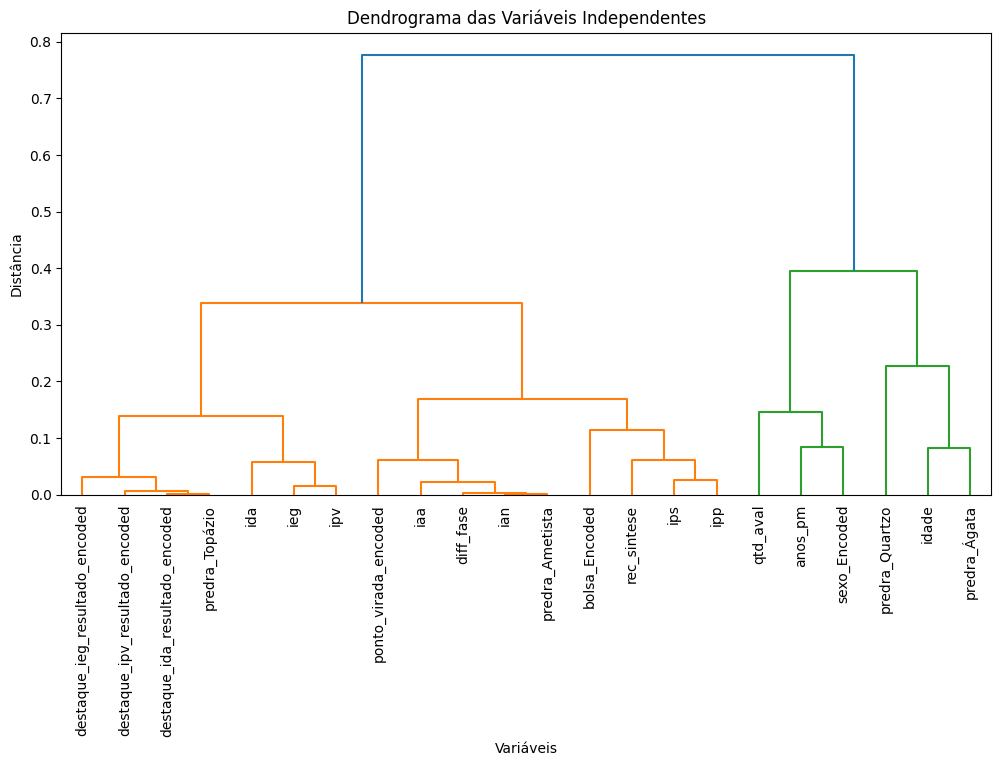

In [38]:
# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes)

# Calcular a matriz de distância usando a diferença absoluta
distancias = pdist(correlacoes_array.reshape(-1, 1), metric="cityblock")

# Realizar a clusterização hierárquica
Z = linkage(distancias, method="average")

# Plotar o dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=variaveis_independentes, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma das Variáveis Independentes")
plt.xlabel("Variáveis")
plt.ylabel("Distância")
plt.show()


In [40]:
import plotly.figure_factory as ff

# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes)

# Calcular a matriz de distância usando a diferença absoluta
distancias = pdist(correlacoes_array.reshape(-1, 1), metric="cityblock")

# Realizar a clusterização hierárquica
Z = linkage(distancias, method="average")

# Criar o dendrograma usando Plotly
fig = ff.create_dendrogram(
    correlacoes_array.reshape(-1, 1),
    orientation="bottom",
    labels=variaveis_independentes,
    linkagefun=lambda x: linkage(x, method="average", metric="cityblock"),
)

# Ajustar o layout para evitar sobreposição das legendas
fig.update_layout(
    width=1200,
    height=600,
    title="Dendrograma das Variáveis Independentes",
    xaxis_title="Variáveis",
    yaxis_title="Distância",
    xaxis=dict(tickangle=-90, tickfont=dict(size=10), automargin=True),
    margin=dict(b=200),
)

# Exibir o dendrograma
fig.show()


In [59]:
import plotly.graph_objects as go

# Método do Cotovelo usando Plotly
K = range(1, 10)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(correlacoes_array)
    inertias.append(kmeans.inertia_)

# Criar o gráfico interativo com Plotly
fig_elbow = go.Figure()
fig_elbow.add_trace(
    go.Scatter(
        x=list(K),
        y=inertias,
        mode="lines+markers",
        marker=dict(color="blue"),
        line=dict(dash="solid"),
        name="Inércia",
    )
)

fig_elbow.update_layout(
    title="Método do Cotovelo para K-Means",
    xaxis_title="Número de Clusters K",
    yaxis_title="Inércia",
    xaxis=dict(tickmode="linear"),
    template="plotly_white",
)

fig_elbow.show()


In [60]:
from sklearn.metrics import silhouette_score

# Coeficiente de Silhueta usando Plotly
silhouette_scores = []
K_silhouette = range(2, 10)  # O coeficiente de silhueta não está definido para k=1

for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(correlacoes_array)
    score = silhouette_score(correlacoes_array, labels)
    silhouette_scores.append(score)

# Criar o gráfico interativo com Plotly
fig_silhouette = go.Figure()
fig_silhouette.add_trace(
    go.Scatter(
        x=list(K_silhouette),
        y=silhouette_scores,
        mode="lines+markers",
        marker=dict(color="green"),
        line=dict(dash="solid"),
        name="Coeficiente de Silhueta",
    )
)

fig_silhouette.update_layout(
    title="Análise do Coeficiente de Silhueta para K-Means",
    xaxis_title="Número de Clusters K",
    yaxis_title="Coeficiente de Silhueta",
    xaxis=dict(tickmode="linear"),
    template="plotly_white",
)

fig_silhouette.show()


In [68]:
import plotly.graph_objects as go

# Converter as correlações em um array numpy
correlacoes_array = np.array(correlacoes).reshape(-1, 1)

# Definir o número de clusters (por exemplo, 4)
k = 4

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(correlacoes_array)
labels = kmeans.labels_

# Criar um DataFrame com os resultados
df_clusters = pd.DataFrame(
    {"Variavel": variaveis_independentes, "Correlacao": correlacoes, "Cluster": labels}
)

# Ordenar o DataFrame para melhor visualização
df_clusters = df_clusters.sort_values(by="Correlacao").reset_index(drop=True)

# Visualizar os clusters usando Plotly
fig = go.Figure()

# Definir cores para os clusters
colors = [
    "red",
    "blue",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

for cluster in range(k):
    cluster_data = df_clusters[df_clusters["Cluster"] == cluster]
    fig.add_trace(
        go.Scatter(
            x=cluster_data["Variavel"],
            y=cluster_data["Correlacao"],
            mode="markers",
            marker=dict(size=10, color=colors[cluster % len(colors)]),
            name=f"Cluster {cluster}",
        )
    )

fig.update_layout(
    title="K-Means Clustering das Variáveis Independentes",
    xaxis_title="Variáveis",
    yaxis_title="Correlação",
    xaxis=dict(tickangle=-90),
    legend_title="Clusters",
    template="plotly_white",
)

fig.show()
